In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-01 00:30:28.984082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 00:30:28.993875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 00:30:28.994426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps according to the reference paper

In [15]:
def trainPreprocessA(img, lab):
        
        img = tf.image.random_crop(img, [CROP_HEIGHT, CROP_WIDTH, 3])
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        img = tf.clip_by_value(img, 0.0, 255.0)
        
        return img, lab

In [16]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [17]:
def extractGenderLabel(img, lab):
    
    lab = lab['gender']
    
    return img, lab

In [18]:
def extractAgeLabel(img, lab):
    
    lab = lab['age']
    
    return img, lab

### Generate Folds for K-Folds validation

In [19]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [20]:
trainPreBatch = [("train_process_a", trainPreprocessA), 
                 ("train_extract_gender", extractGenderLabel)]

valPreBatch = [("val_process_a", valPreprocessA), 
               ("val_extract_gender", extractGenderLabel)]

In [21]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-01 00:30:29.238107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 00:30:29.238855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 00:30:29.239202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 00:30:29.239501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [22]:
len(folds)

5

### Check data

In [23]:
for x,y in folds[0][0].take(1):
    pass

In [24]:
x

<tf.Tensor: shape=(4, 227, 227, 3), dtype=float32, numpy=
array([[[[8.15251617e+01, 5.97867203e+01, 5.23324203e+01],
         [8.15251617e+01, 5.97867203e+01, 5.23324203e+01],
         [8.15251617e+01, 5.97867203e+01, 5.23324203e+01],
         ...,
         [8.15251617e+01, 5.97867203e+01, 5.23324203e+01],
         [8.15251617e+01, 5.97867203e+01, 5.23324203e+01],
         [8.15251617e+01, 5.97867203e+01, 5.23324203e+01]],

        [[8.15251617e+01, 5.97867203e+01, 5.23324203e+01],
         [8.15251617e+01, 5.97867203e+01, 5.23324203e+01],
         [8.15251617e+01, 5.97867203e+01, 5.23324203e+01],
         ...,
         [8.15251617e+01, 5.97867203e+01, 5.23324203e+01],
         [8.15251617e+01, 5.97867203e+01, 5.23324203e+01],
         [8.15251617e+01, 5.97867203e+01, 5.23324203e+01]],

        [[8.15251617e+01, 5.97867203e+01, 5.23324203e+01],
         [8.15251617e+01, 5.97867203e+01, 5.23324203e+01],
         [8.15251617e+01, 5.97867203e+01, 5.23324203e+01],
         ...,
         [8

In [25]:
y

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)>

<IPython.core.display.Javascript object>


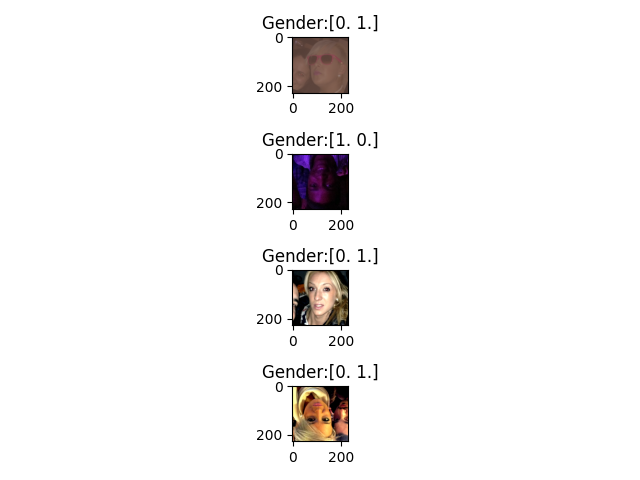

In [26]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y[i]}")
        
plt.tight_layout()

### Model

In [27]:
def createModel():
    inp = tf.keras.Input(shape=(CROP_HEIGHT, CROP_WIDTH, 3))

    conv1 = tf.keras.layers.Conv2D(64, 7, strides=(4,4), activation='relu', name='conv1')
    pool1 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, name='pool1')

    conv2 = tf.keras.layers.Conv2D(128, 5, activation='relu', name='conv2')
    pool2 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, name='pool2')

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', name='conv3')
    pool3 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, name='pool3')

    flat1 = tf.keras.layers.Flatten(name='flat1')
    fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='fc2')

    o = conv1(inp)
    o = pool1(o)

    o = conv2(o)
    o = pool2(o)

    o = conv3(o)
    o = pool3(o)

    o = flat1(o)
    o = fc1(o)
    o = do1(o)

    o = fc2(o)

    model = tf.keras.models.Model(inputs=inp, outputs=o, name='CNN_1')
    
    return model

In [28]:
model = createModel()

In [29]:
model.summary()

Model: "CNN_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 56, 56, 64)        9472      
                                                                 
 pool1 (MaxPooling2D)        (None, 27, 27, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 23, 23, 128)       204928    
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 11, 128)       0         
                                                                 
 conv3 (Conv2D)              (None, 9, 9, 256)         295168    
                                                                 
 pool3 (MaxPooling2D)        (None, 4, 4, 256)         0     

### Compile Model

In [30]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [31]:
def schedule(epoch, lr):
    return lr

In [32]:
logBasePath = "log/CNN_1"
logPrefix = "log"

In [33]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel()
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0000001)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = ['accuracy']
    
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-01 00:30:31.902881: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-01 00:30:31.902898: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-01 00:30:31.902919: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-01 00:30:31.996486: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-01 00:30:31.997727: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-01 00:30:32.536405: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  83/3528 [..............................] - ETA: 6s - loss: 17.3704 - accuracy: 0.3765   

2022-11-01 00:30:33.314102: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 8s 2ms/step - loss: 13.0023 - accuracy: 0.5233
Epoch 1/300
   1/1000 [..............................] - ETA: 6:58 - loss: 26.4011 - accuracy: 0.2500

2022-11-01 00:30:39.965216: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-01 00:30:39.965243: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  49/1000 [>.............................] - ETA: 12s - loss: 23.1700 - accuracy: 0.4439

2022-11-01 00:30:40.384539: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-01 00:30:40.385188: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-01 00:30:40.409964: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 1167 callback api events and 1142 activity events. 
2022-11-01 00:30:40.420440: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-01 00:30:40.432830: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/CNN_1/log_0/plugins/profile/2022_11_01_00_30_40

2022-11-01 00:30:40.450998: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/CNN_1/log_0/plugins/profile/2022_11_01_00_30_40/rachanon-pc1.trace.json.gz
2022-11-01 00:30:40.471342: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log

1000/1000 [==============================] - 9s 8ms/step - loss: 15.2391 - accuracy: 0.5010 - val_loss: 2.7705 - val_accuracy: 0.5649
Epoch 2/300
1000/1000 [==============================] - 8s 8ms/step - loss: 12.7217 - accuracy: 0.4940 - val_loss: 2.0521 - val_accuracy: 0.5834
Epoch 3/300
1000/1000 [==============================] - 8s 8ms/step - loss: 11.7741 - accuracy: 0.5190 - val_loss: 1.9620 - val_accuracy: 0.5906
Epoch 4/300
1000/1000 [==============================] - 8s 8ms/step - loss: 11.5119 - accuracy: 0.5090 - val_loss: 1.9299 - val_accuracy: 0.5903
Epoch 5/300
1000/1000 [==============================] - 8s 8ms/step - loss: 9.3063 - accuracy: 0.5295 - val_loss: 1.8746 - val_accuracy: 0.5956
Epoch 6/300
1000/1000 [==============================] - 8s 8ms/step - loss: 9.6244 - accuracy: 0.5100 - val_loss: 2.0587 - val_accuracy: 0.5919
Epoch 7/300
1000/1000 [==============================] - 8s 8ms/step - loss: 8.6134 - accuracy: 0.5173 - val_loss: 2.1337 - val_accuracy: 

1000/1000 [==============================] - 8s 8ms/step - loss: 0.7977 - accuracy: 0.5330 - val_loss: 0.6966 - val_accuracy: 0.5748
Epoch 58/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7757 - accuracy: 0.5652 - val_loss: 0.6968 - val_accuracy: 0.5754
Epoch 59/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7721 - accuracy: 0.5523 - val_loss: 0.6937 - val_accuracy: 0.5798
Epoch 60/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7624 - accuracy: 0.5420 - val_loss: 0.6926 - val_accuracy: 0.5812
Epoch 61/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7602 - accuracy: 0.5380 - val_loss: 0.6899 - val_accuracy: 0.5798
Epoch 62/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7600 - accuracy: 0.5437 - val_loss: 0.6885 - val_accuracy: 0.5799
Epoch 63/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7417 - accuracy: 0.5592 - val_loss: 0.6867 - val_accuracy

1000/1000 [==============================] - 8s 8ms/step - loss: 0.6904 - accuracy: 0.5683 - val_loss: 0.6643 - val_accuracy: 0.6133
Epoch 114/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6804 - accuracy: 0.5813 - val_loss: 0.6640 - val_accuracy: 0.6197
Epoch 115/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6869 - accuracy: 0.5645 - val_loss: 0.6639 - val_accuracy: 0.6193
Epoch 116/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6760 - accuracy: 0.5982 - val_loss: 0.6625 - val_accuracy: 0.6165
Epoch 117/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6864 - accuracy: 0.5692 - val_loss: 0.6632 - val_accuracy: 0.6181
Epoch 118/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6695 - accuracy: 0.5968 - val_loss: 0.6629 - val_accuracy: 0.6205
Epoch 119/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6825 - accuracy: 0.6008 - val_loss: 0.6620 - val_ac

Epoch 169/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6711 - accuracy: 0.6072 - val_loss: 0.6542 - val_accuracy: 0.6262
Epoch 170/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6805 - accuracy: 0.5650 - val_loss: 0.6548 - val_accuracy: 0.6270
Epoch 171/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6730 - accuracy: 0.5860 - val_loss: 0.6557 - val_accuracy: 0.6281
Epoch 172/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6643 - accuracy: 0.6080 - val_loss: 0.6538 - val_accuracy: 0.6212
Epoch 173/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6748 - accuracy: 0.5792 - val_loss: 0.6534 - val_accuracy: 0.6236
Epoch 174/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6721 - accuracy: 0.5880 - val_loss: 0.6531 - val_accuracy: 0.6272
Epoch 175/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6839 - accuracy: 0.5732 - val_loss: 0

Epoch 225/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6571 - accuracy: 0.6250 - val_loss: 0.6452 - val_accuracy: 0.6297
Epoch 226/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6719 - accuracy: 0.5782 - val_loss: 0.6451 - val_accuracy: 0.6310
Epoch 227/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6607 - accuracy: 0.6015 - val_loss: 0.6442 - val_accuracy: 0.6331
Epoch 228/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6763 - accuracy: 0.5773 - val_loss: 0.6450 - val_accuracy: 0.6299
Epoch 229/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6624 - accuracy: 0.6075 - val_loss: 0.6447 - val_accuracy: 0.6316
Epoch 230/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6670 - accuracy: 0.5842 - val_loss: 0.6448 - val_accuracy: 0.6315
Epoch 231/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6620 - accuracy: 0.6165 - val_loss: 0

Epoch 281/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6654 - accuracy: 0.5928 - val_loss: 0.6402 - val_accuracy: 0.6312
Epoch 282/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6575 - accuracy: 0.6152 - val_loss: 0.6392 - val_accuracy: 0.6333
Epoch 283/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6704 - accuracy: 0.5945 - val_loss: 0.6392 - val_accuracy: 0.6372
Epoch 284/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6538 - accuracy: 0.6087 - val_loss: 0.6387 - val_accuracy: 0.6430
Epoch 285/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6480 - accuracy: 0.6263 - val_loss: 0.6394 - val_accuracy: 0.6335
Epoch 286/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6668 - accuracy: 0.5805 - val_loss: 0.6389 - val_accuracy: 0.6352
Epoch 287/300
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6572 - accuracy: 0.6093 - val_loss: 0